## Package Installaion

In [1]:
%pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to c:\users\sunny\appdata\local\temp\pip-req-build-bf_jkpxl
  Resolved https://github.com/ourownstory/neural_prophet.git to commit a979aa34ecbf8f3bd576623e5ffcd3feee5edafe
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 1.4/1.4 MB 22.5 MB/s eta 0:00:00
  Created wheel for neuralprophet: filename=neuralprophet-0.5.0-py3-none-any.whl size=114423 sha256=0e79a2558689baca790dabb0388766bc88f4d83947646bcb74c876cb9563714a
  Stored in directory: C:\Users\sunny\AppData\Local\Temp\pip-ephem-wheel-cache-mcms57sn\wheels\32\ce\37\d289cb9c67e62f7912fc3a25e624277ea47902c32e24371a78
Successfully built neuralprophet
  Atte

  Running command git clone --filter=blob:none --quiet https://github.com/ourownstory/neural_prophet.git 'C:\Users\sunny\AppData\Local\Temp\pip-req-build-bf_jkpxl'


In [19]:
%pip install matplotlib
%pip install seaborn
%pip install pickle
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


Note: you may need to restart the kernel to use updated packages.


## Package Importation

In [20]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan
import neuralprophet

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

from collections import defaultdict

import copy

import pickle

## Reading Data

Below we read in the data for train, val and test as well as the associated historical dataframe

In [21]:
IT_sector_historical = pd.read_csv('../data_processing/it_history.csv', index_col=0)

In [22]:
train = pd.read_csv('../data_processing/train_daily.csv', index_col=0).T.reset_index(level=0).rename(columns={'index':'ds'})
val = pd.read_csv('../data_processing/val_daily.csv', index_col=0).T.iloc[1:,:].reset_index(level=0).rename(columns={'index':'ds'})
test = pd.read_csv('../data_processing/test_daily.csv', index_col=0).T.reset_index(level=0).rename(columns={'index':'ds'})

In [23]:
earnings_10yr_df = pd.read_csv('../data_processing/earnings_10yr_past_future_df.csv')

### Creating Valid DataFrame Tickers

In [24]:
industry_symbol = IT_sector_historical[['GICS Sector', 'Symbol']]
industry_symbol.to_csv('industry_symbol.csv')

In [25]:
train = train.rename(columns=pd.Series(industry_symbol['Symbol']).to_dict())
val = val.rename(columns=pd.Series(industry_symbol['Symbol']).to_dict())
test = test.rename(columns=pd.Series(industry_symbol['Symbol']).to_dict())

## Auxiliary Plotting Functions

In [26]:
def plot_forecast(model, data, periods=0, historic_pred=True, highlight_steps_ahead=None, xlabel='Date', ylabel=None, title=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    fig, ax = plt.subplots(figsize=(14,10))

    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

    else:    
        model.plot(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

In [27]:
def plot_validation(metrics_df, metrics = ['SmoothL1Loss', 'MAE', 'RMSE']):
    met_len = len(metrics)

    fig, axs = plt.subplots(ncols=len(metrics), nrows=1, sharex=True, sharey=True, figsize=(8*met_len, 8))
    fig.suptitle('Validation Metrics', fontsize=20, y=0.95)

    if met_len == 1:
        metric = metrics[0]
        axs.plot(metrics_df[metric], 'ob', linewidth=6, label='training loss', markersize='3')
        axs.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='validation loss')

        axs.set_xlabel('training loss')
        axs.set_ylabel('validation loss')
        axs.set_title(metric)
        axs.legend()
    else:
        for metric, ax in zip(metrics, axs.ravel()):
            ax.plot(metrics_df[metric], 'ob', linewidth=6, label='training loss', markersize='3')
            ax.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='validation loss')

            ax.set_xlabel('training loss')
            ax.set_ylabel('validation loss')
            ax.set_title(metric)
            ax.legend()

## Base Model (Train)
---

Below we define the base model alongside the addition of country holidays in the US

In [28]:
base_model = NeuralProphet(
    """
    Parameters
        ----------
            COMMENT
            Trend Config
            COMMENT
            growth : {'off' or 'linear'}, default 'linear'
                Set use of trend growth type.
                Options:
                    * ``off``: no trend.
                    * (default) ``linear``: fits a piece-wise linear trend with ``n_changepoints + 1`` segments
                    * ``discontinuous``: For advanced users only - not a conventional trend,
                    allows arbitrary jumps at each trend changepoint
            changepoints : {list of str, list of np.datetimes or np.array of np.datetimes}, optional
                Manually set dates at which to include potential changepoints.
                Note
                ----
                Does not accept ``np.array`` of ``np.str``. If not specified, potential changepoints are selected automatically.
            n_changepoints : int
                Number of potential trend changepoints to include.
                Note
                ----
                Changepoints are selected uniformly from the first ``changepoint_range`` proportion of the history.
                Ignored if manual ``changepoints`` list is supplied.
            changepoints_range : float
                Proportion of history in which trend changepoints will be estimated.
                e.g. set to 0.8 to allow changepoints only in the first 80% of training data.
                Ignored if  manual ``changepoints`` list is supplied.
            trend_reg : float, optional
                Parameter modulating the flexibility of the automatic changepoint selection.
                Note
                ----
                Large values (~1-100) will limit the variability of changepoints.
                Small values (~0.001-1.0) will allow changepoints to change faster.
                default: 0 will fully fit a trend to each segment.
            trend_reg_threshold : bool, optional
                Allowance for trend to change without regularization.
                Options
                    * ``True``: Automatically set to a value that leads to a smooth trend.
                    * (default) ``False``: All changes in changepoints are regularized
            trend_global_local : str, default 'global'
                Modelling strategy of the trend when multiple time series are present.
                Options:
                    * ``global``: All the elements are modelled with the same trend.
                    * ``local``: Each element is modelled with a different trend.
                Note
                ----
                When only one time series is input, this parameter should not be provided.
                Internally it will be set to ``global``, meaning that all the elements(only one in this case)
                are modelled with the same trend.
            COMMENT
            Seasonality Config
            COMMENT
            yearly_seasonality : bool, int
                Fit yearly seasonality.
                Options
                    * ``True`` or ``False``
                    * ``auto``: set automatically
                    * ``value``: number of Fourier/linear terms to generate
            weekly_seasonality : bool, int
                Fit monthly seasonality.
                Options
                    * ``True`` or ``False``
                    * ``auto``: set automatically
                    * ``value``: number of Fourier/linear terms to generate
            daily_seasonality : bool, int
                Fit daily seasonality.
                Options
                    * ``True`` or ``False``
                    * ``auto``: set automatically
                    * ``value``: number of Fourier/linear terms to generate
            seasonality_mode : str
                Specifies mode of seasonality
                Options
                    * (default) ``additive``
                    * ``multiplicative``
            seasonality_reg : float, optional
                Parameter modulating the strength of the seasonality model.
                Note
                ----
                Smaller values (~0.1-1) allow the model to fit larger seasonal fluctuations,
                larger values (~1-100) dampen the seasonality.
                default: None, no regularization
            season_global_local : str, default 'global'
                Modelling strategy of the seasonality when multiple time series are present.
                Options:
                    * ``global``: All the elements are modelled with the same seasonality.
                    * ``local``: Each element is modelled with a different seasonality.
                Note
                ----
                When only one time series is input, this parameter should not be provided.
                Internally it will be set to ``global``, meaning that all the elements(only one in this case)
                are modelled with the same seasonality.
            COMMENT
            AR Config
            COMMENT
            n_lags : int
                Previous time series steps to include in auto-regression. Aka AR-order
            ar_reg : float, optional
                how much sparsity to induce in the AR-coefficients
                Note
                ----
                Large values (~1-100) will limit the number of nonzero coefficients dramatically.
                Small values (~0.001-1.0) will allow more non-zero coefficients.
                default: 0 no regularization of coefficients.
            COMMENT
            Model Config
            COMMENT
            n_forecasts : int
                Number of steps ahead of prediction time step to forecast.
            num_hidden_layers : int, optional
                number of hidden layer to include in AR-Net (defaults to 0)
            d_hidden : int, optional
                dimension of hidden layers of the AR-Net. Ignored if ``num_hidden_layers`` == 0.
            COMMENT
            Train Config
            COMMENT
            learning_rate : float
                Maximum learning rate setting for 1cycle policy scheduler.
                Note
                ----
                Default ``None``: Automatically sets the ``learning_rate`` based on a learning rate range test.
                For manual user input, (try values ~0.001-10).
            epochs : int
                Number of epochs (complete iterations over dataset) to train model.
                Note
                ----
                Default ``None``: Automatically sets the number of epochs based on dataset size.
                For best results also leave batch_size to None. For manual values, try ~5-500.
            batch_size : int
                Number of samples per mini-batch.
                If not provided, ``batch_size`` is approximated based on dataset size.
                For manual values, try ~8-1024.
                For best results also leave ``epochs`` to ``None``.
            newer_samples_weight: float, default 2.0
                Sets factor by which the model fit is skewed towards more recent observations.
                Controls the factor by which final samples are weighted more compared to initial samples.
                Applies a positional weighting to each sample's loss value.
                e.g. ``newer_samples_weight = 2``: final samples are weighted twice as much as initial samples.
            newer_samples_start: float, default 0.0
                Sets beginning of 'newer' samples as fraction of training data.
                Throughout the range of 'newer' samples, the weight is increased
                from ``1.0/newer_samples_weight`` initially to 1.0 at the end,
                in a monotonously increasing function (cosine from pi to 2*pi).
            loss_func : str, torch.nn.functional.loss
                Type of loss to use:
                Options
                    * (default) ``Huber``: Huber loss function
                    * ``MSE``: Mean Squared Error loss function
                    * ``MAE``: Mean Absolute Error loss function
                    * ``torch.nn.functional.loss.``: loss or callable for custom loss, eg. L1-Loss
                Examples
                --------
                >>> from neuralprophet import NeuralProphet
                >>> import torch
                >>> import torch.nn as nn
                >>> m = NeuralProphet(loss_func=torch.nn.L1Loss)
            collect_metrics : list of str, dict, bool
                Set metrics to compute.
                Options
                    * (default) ``True``: [``mae``, ``rmse``]
                    * ``False``: No metrics
                    * ``list``:  Valid options: [``mae``, ``rmse``, ``mse``]
                    * ``dict``:  Collection of torchmetrics.Metric objects
                Examples
                --------
                >>> from neuralprophet import NeuralProphet
                >>> m = NeuralProphet(collect_metrics=["MSE", "MAE", "RMSE"])
            COMMENT
            Uncertainty Estimation
            COMMENT
            quantiles : list, default None
                A list of float values between (0, 1) which indicate the set of quantiles to be estimated.
            COMMENT
            Missing Data
            COMMENT
            impute_missing : bool
                whether to automatically impute missing dates/values
                Note
                ----
                imputation follows a linear method up to 20 missing values, more are filled with trend.
            impute_linear : int
                maximal number of missing dates/values to be imputed linearly (default: ``10``)
            impute_rolling : int
                maximal number of missing dates/values to be imputed
                using rolling average (default: ``10``)
            drop_missing : bool
                whether to automatically drop missing samples from the data
                Options
                    * (default) ``False``: Samples containing NaN values are not dropped.
                    * ``True``: Any sample containing at least one NaN value will be dropped.
            COMMENT
            Data Normalization
            COMMENT
            normalize : str
                Type of normalization to apply to the time series.
                Options
                    * ``off`` bypasses data normalization
                    * (default, binary timeseries) ``minmax`` scales the minimum value to 0.0 and the maximum value to 1.0
                    * ``standardize`` zero-centers and divides by the standard deviation
                    * (default) ``soft`` scales the minimum value to 0.0 and the 95th quantile to 1.0
                    * ``soft1`` scales the minimum value to 0.1 and the 90th quantile to 0.9
            global_normalization : bool
                Activation of global normalization
                Options
                    * ``True``: dict of dataframes is used as global_time_normalization
                    * (default) ``False``: local normalization
            global_time_normalization : bool
                Specifies global time normalization
                Options
                    * (default) ``True``: only valid in case of global modeling local normalization
                    * ``False``: set time data_params locally
            unknown_data_normalization : bool
                Specifies unknown data normalization
                Options
                    * ``True``: test data is normalized with global data params even if trained with local data params (global modeling with local normalization)
                    * (default) ``False``: no global modeling with local normalization
            accelerator: str
                Name of accelerator from pytorch_lightning.accelerators to use for training. Use "auto" to automatically select an available accelerator.
                Provide `None` to deactivate the use of accelerators.
            trainer_config: dict
                Dictionary of additional trainer configuration parameters.
    """
    growth='discontinuous',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, # To include 7 days worth of AR lag
    num_hidden_layers=8, # 8 hidden layers for the network
    d_hidden=64, # Dimension of hidden layers of AR-Net
    learning_rate=None, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)

base_model.add_country_holidays('USA') # Adds effects of US holidays

## Additive Events

In [29]:
CES_dates_df = pd.DataFrame(
    {
        "event": "CES Show",
        "ds": pd.to_datetime(
            [
                "2012-01-11",
                "2013-01-10",
                "2013-01-09",
                "2014-01-05",
                "2015-01-09",
                "2016-01-07",
                "2017-01-06",
                "2018-01-10",
                "2019-01-09",
                "2020-01-08",
                "2021-01-12",
                "2022-01-05",
                "2023-01-06",
            ]
        ),
    }
)

AAPL_dates_df = pd.DataFrame(
    {
        "event": "AAPL Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['aapl']
        ),
    }
)

META_dates_df = pd.DataFrame(
    {
        "event": "META Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['meta']
        ),
    }
)

GOOG_dates_df = pd.DataFrame(
    {
        "event": "GOOG Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['goog']
        ),
    }
)

NFLX_dates_df = pd.DataFrame(
    {
        "event": "NFLX Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['nflx']
        ),
    }
)

AMZN_dates_df = pd.DataFrame(
    {
        "event": "AMZN Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['amzn']
        ),
    }
)

MSFT_dates_df = pd.DataFrame(
    {
        "event": "MSFT Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['msft']
        ),
    }
)

NVDA_dates_df = pd.DataFrame(
    {
        "event": "NVDA Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['nvda']
        ),
    }
)

AMD_dates_df = pd.DataFrame(
    {
        "event": "AMD Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['amd']
        ),
    }
)

INTC_dates_df = pd.DataFrame(
    {
        "event": "INTC Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['intc']
        ),
    }
)

### Create Events Dataframe for IT Sector

In [30]:
event_names = [
    'CES Show',
    'AAPL Earnings', 
    'META Earnings', 
    'GOOG Earnings', 
    'NFLX Earnings', 
    'AMZN Earnings',
    'MSFT Earnings',
    'NVDA Earnings',
    'AMD Earnings',
    'INTC Earnings',
]

In [31]:
events_df = pd.concat(
    (
        CES_dates_df,
        AAPL_dates_df,
        META_dates_df,
        GOOG_dates_df,
        NFLX_dates_df,
        AMZN_dates_df,
        MSFT_dates_df,
        NVDA_dates_df,
        AMD_dates_df,
        INTC_dates_df
    ),
)

In [32]:
events_df

,event,ds
0,CES Show,2012-01-11
1,CES Show,2013-01-10
2,CES Show,2013-01-09
3,CES Show,2014-01-05
4,CES Show,2015-01-09
...,...,...
43,INTC Earnings,2013-01-17
44,INTC Earnings,2012-10-16
45,INTC Earnings,2012-07-17
46,INTC Earnings,2012-04-17


## Train & Fit Model

In [33]:
%%script false --no-raise-error

READ_IN_MODEL_AND_METRICS = False
IS_ADDITIVE = False

models_dict = dict()

for symbol in train.columns:
    if symbol == 'ds': continue

    additive_str = '_additive' if IS_ADDITIVE else ''
    if READ_IN_MODEL_AND_METRICS:
        with open(f'./model/model_pickles{additive_str}/{symbol}_model.pkl', 'rb') as f:
            model = pickle.load(f)
        with open(f'./model/model_metrics{additive_str}/{symbol}_metrics.csv', 'rb') as f:
            metrics = pd.read_csv(f)

    else:
        set_random_seed(0)
        model = copy.deepcopy(base_model)

        train_with_dates_df = train[[symbol, 'ds']].rename(columns={symbol: 'y'})
        val_with_dates_df = val[[symbol, 'ds']].rename(columns={symbol: 'y'})
        test_with_dates_df = test[[symbol, 'ds']].rename(columns={symbol: 'y'})

        if IS_ADDITIVE:
            model.add_events(event_names, lower_window=-1, upper_window=1)

            train_with_dates_df = model.create_df_with_events(train_with_dates_df, events_df)
            val_with_dates_df = model.create_df_with_events(val_with_dates_df, events_df)
            test_with_dates_df = model.create_df_with_events(test_with_dates_df, events_df)

        metrics = model.fit(
            df=train_with_dates_df,
            freq='D',
            validation_df=val_with_dates_df,
            progress='bar'
        )

        model_path = f'../model/model_pickles{additive_str}/{symbol}_model.pickle'
        metrics_path = f'../model/model_metrics{additive_str}/{symbol}_metrics.pickle'

        with open(model_path, 'wb') as handle:
            pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(metrics_path, 'wb') as handle:
            pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

    models_dict[symbol] = [model, metrics]

## Loading Pickles

In [91]:
SYMBOL = 'JKHY'
IS_ADDITIVE = True

additive = '_additive' if IS_ADDITIVE else ''
additive_name = 'added_' if IS_ADDITIVE else ''

MODEL_PATH = f'../model/model_pickles{additive}/{SYMBOL}_{additive_name}model.pickle'
METRICS_PATH = f'../model/model_metrics{additive}/{SYMBOL}_{additive_name}metric.pickle'

In [92]:
model = pickle.load(open(MODEL_PATH, 'rb'))
metrics = pickle.load(open(METRICS_PATH, 'rb'))

In [94]:
test_inp = test[[SYMBOL, 'ds']].rename(columns={SYMBOL: 'y'})
historical_test_df = test_inp if not IS_ADDITIVE else model.create_df_with_events(test_inp, events_df)
future = model.make_future_dataframe(df=historical_test_df, periods=365, n_historic_predictions=len(historical_test_df))

forecast = model.predict(df=future)
forecast.columns

Index(['ds', 'y', 'residual1', 'yhat1', 'ar1', 'trend', 'season_yearly',
       'season_weekly', 'events_additive', 'event_AAPL Earnings',
       'event_AMD Earnings', 'event_AMZN Earnings', 'event_CES Show',
       'event_GOOG Earnings', 'event_INTC Earnings', 'event_META Earnings',
       'event_MSFT Earnings', 'event_NFLX Earnings', 'event_NVDA Earnings'],
      dtype='object')

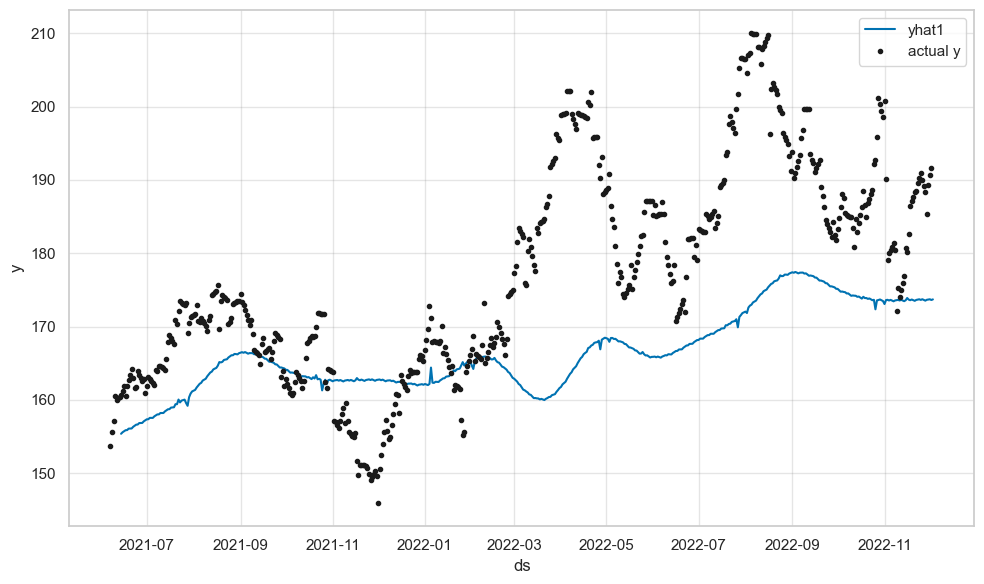

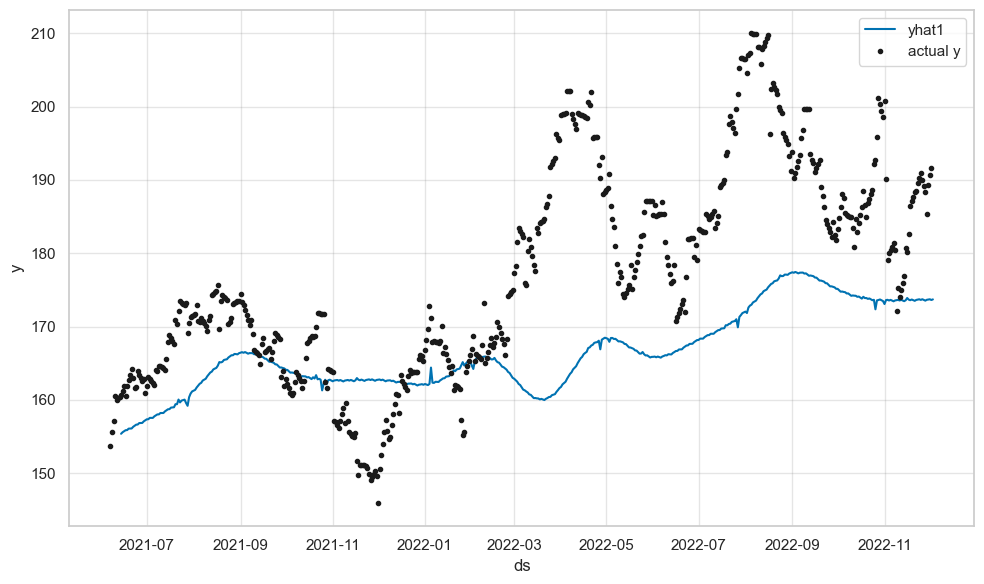

In [95]:
model.plot(forecast)

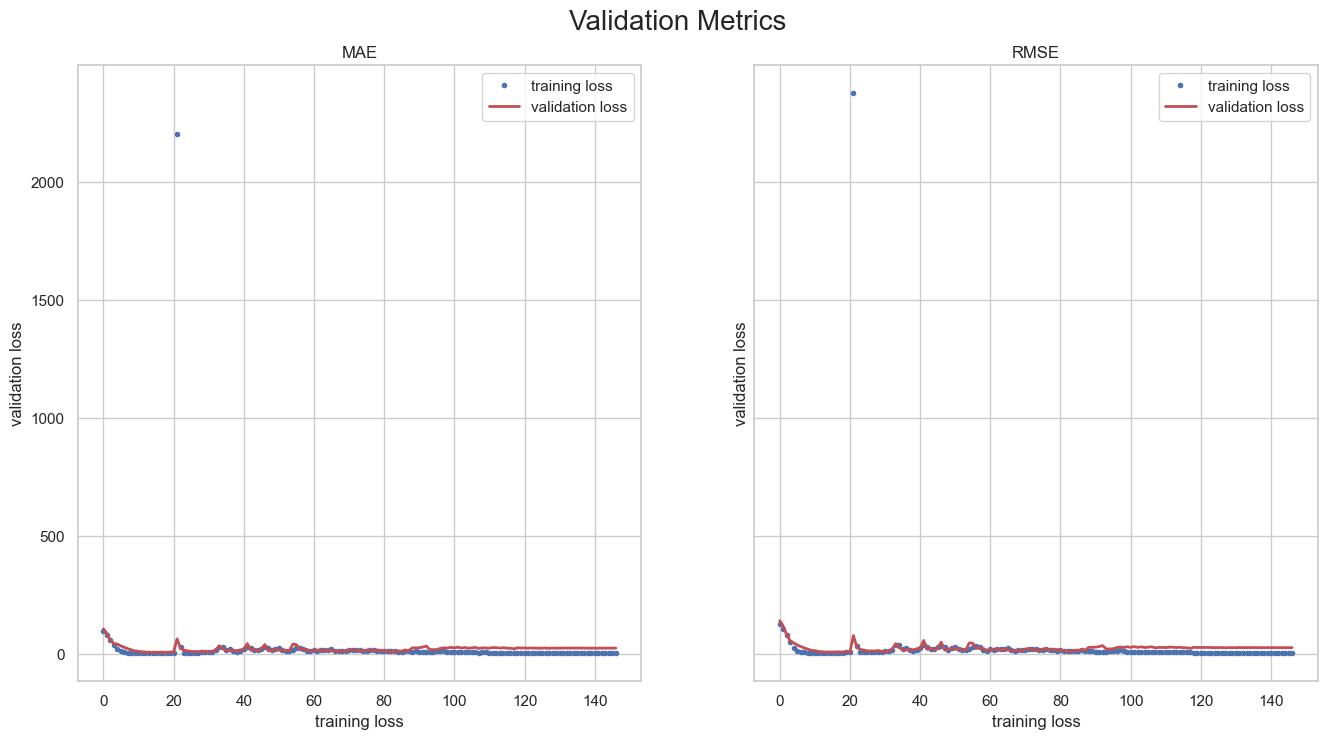

In [96]:
plot_validation(metrics_df=metrics, metrics = ['MAE', 'RMSE'])

## Obtaining Associated Weights

In [ ]:
for symbol in train.columns:
    if symbol == 'ds': continue
    
    MODEL_PATH = f'../model/model_pickles_additive/{symbol}_added_model.pickle'
    model = pickle.load(open(MODEL_PATH, 'rb'))
    
    test_inp = test[[SYMBOL, 'ds']].rename(columns={SYMBOL: 'y'})
    historical_test_df = model.create_df_with_events(test_inp, events_df)
    future = model.make_future_dataframe(df=historical_test_df, periods=365, n_historic_predictions=len(historical_test_df))

    forecast = model.predict(df=future)
    forecast.columns

## Creating & Predicting Into Future

In [41]:
%%script false --no-raise-error

model = models_dict['AAPL'][0]
metrics = models_dict['AAPL'][1]
historical_train_df = models_dict['AAPL'][2]
historical_val_df = models_dict['AAPL'][3]

In [42]:
%%script false --no-raise-error

future = model.make_future_dataframe(df=historical_train_df, events_df=events_df, periods=365, n_historic_predictions=len(train))
forecast = model.predict(df=future)

## Deprecated Code with Multiple Industries

In [43]:
%%script false --no-raise-error

has_historical_df = False
read_in_model_and_metrics = False
model_dict = defaultdict()

for industry, symbols in industry_to_symbol_map.items():
    model_dict[industry] = defaultdict()
    for symbol in symbols:
        model_dict[industry][symbol] = {
            'model': None,
            'metrics': None,
        }

        if read_in_model_and_metrics:
            model_dict[industry][symbol]['model'] = pickle.load('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/model.pkl')
            model_dict[industry][symbol]['metrics'] = pickle.load('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/metrics.pkl')
        else:
            model = base_model
            # model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1)
            model = model.add_events(additive_events[industry])

            ## Reads in historical_df if has_historical_df else creates & writes historical_df
            if has_historical_df:
                historical_df = pd.read_csv('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/historical_df.csv')
            else:
                historical_df = model.create_df_with_events(train[:, symbol_to_index_map[symbol]], additive_events[industry])
                historical_df.to_csv('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/historical_df.csv', index=False)
            
            metrics = model.fit(historical_df, freq="D", validation_df=val[symbol_to_index_map[symbol]])
            
            ## Updating defaultdict of mdoels
            model_dict[industry][symbol]['model'] = model
            model_dict[industry][symbol]['metrics'] = metrics

            ## Pickling model and metrics
            model_path = './model/' + industry_to_folder_map[industry] + '/' + symbol + '/model'
            metrics_path = './model/' + industry_to_folder_map[industry] + '/' + symbol + '/metrics'

            pickle.dump(model, model_path)
            pickle.dump(metrics, metrics_path)